In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
import matplotlib.pyplot as plt

In [3]:
TRAIN_PATH  = "C:/Users/Admin/Downloads/Telegram Desktop/blurred 25" 
IMG_HEIGHT = 256
IMG_WIDTH = 256
CHANNELS = 1  # Grayscale for X-rays
BATCH_SIZE = 8  # Reduce if memory constrained
EPOCHS = 100
LR_SIZE = (64, 64)  # Low resolution size
HR_SIZE = (IMG_HEIGHT, IMG_WIDTH)  # High resolution size

In [4]:
# Enable mixed precision training (for GPU acceleration)
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Enable XLA compilation
tf.config.optimizer.set_jit(True)

In [5]:
# Residual block for generator
def residual_block(x):
    skip = x
    x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    return layers.Add()([skip, x])

# Optimized Generator
def build_generator():
    input_shape = (LR_SIZE[0], LR_SIZE[1], CHANNELS)
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution
    x = layers.Conv2D(64, kernel_size=9, padding='same')(inputs)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    
    # Residual blocks (reduced from 16 to 8)
    for _ in range(8):
        x = residual_block(x)
    
    # Post residual blocks
    x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([inputs, x])  # Global skip connection
    
    # Upsampling using conv2d + upsampling (faster than subpixel)
    x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
    x = layers.UpSampling2D(size=2)(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    
    x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
    x = layers.UpSampling2D(size=2)(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    
    # Final convolution
    x = layers.Conv2D(CHANNELS, kernel_size=9, padding='same', activation='tanh')(x)
    
    return models.Model(inputs, x, name='generator')

In [6]:
# Optimized Discriminator
def build_discriminator():
    input_shape = (HR_SIZE[0], HR_SIZE[1], CHANNELS)
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, kernel_size=3, padding='same', strides=2)(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(128, kernel_size=3, padding='same', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(256, kernel_size=3, padding='same', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(512, kernel_size=3, padding='same', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(inputs, x, name='discriminator')

In [ ]:
# VGG19 for perceptual loss (modified for grayscale)
def build_vgg():
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    vgg.trainable = False
    
    # Use block3_conv3 features
    outputs = [vgg.get_layer('block3_conv3').output]
    
    return models.Model(vgg.input, outputs)

In [6]:
# SRGAN Model
class SRGAN(models.Model):
    def __init__(self, generator, discriminator, vgg):
        super(SRGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.vgg = vgg
        
    def compile(self, g_optimizer, d_optimizer, bce_loss, mse_loss):
        super(SRGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.bce_loss = bce_loss
        self.mse_loss = mse_loss
        
    def call(self, inputs):
        return self.generator(inputs)
        
    def train_step(self, batch):
        lr_imgs, hr_imgs = batch
        
        # Train discriminator
        with tf.GradientTape() as d_tape:
            # Generate fake images
            fake_imgs = self.generator(lr_imgs, training=True)
            
            # Discriminator loss
            pred_real = self.discriminator(hr_imgs, training=True)
            pred_fake = self.discriminator(fake_imgs, training=True)
            
            d_real_loss = self.bce_loss(tf.ones_like(pred_real), pred_real)
            d_fake_loss = self.bce_loss(tf.zeros_like(pred_fake), pred_fake)
            d_loss = (d_real_loss + d_fake_loss) / 2
            
        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        
        # Train generator
        with tf.GradientTape() as g_tape:
            # Generate fake images
            fake_imgs = self.generator(lr_imgs, training=True)
            
            # Discriminator predictions
            pred_fake = self.discriminator(fake_imgs, training=True)
            
            # Generator losses
            g_bce_loss = self.bce_loss(tf.ones_like(pred_fake), pred_fake)
            
            # VGG feature matching loss
            fake_imgs_rgb = tf.image.grayscale_to_rgb(fake_imgs)
            hr_imgs_rgb = tf.image.grayscale_to_rgb(hr_imgs)
            fake_features = self.vgg(fake_imgs_rgb)
            real_features = self.vgg(hr_imgs_rgb)
            vgg_loss = self.mse_loss(real_features, fake_features)
            
            # Pixel-wise MSE loss
            mse_loss = self.mse_loss(hr_imgs, fake_imgs)
            
            # Total generator loss
            g_loss = 1e-3 * g_bce_loss + 6e-3 * vgg_loss + mse_loss
            
        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))
        
        return {
            "d_loss": d_loss,
            "g_loss": g_loss,
            "g_bce_loss": g_bce_loss,
            "vgg_loss": vgg_loss,
            "mse_loss": mse_loss
        }

In [7]:
# Create tf.data pipeline
def create_dataset(image_paths, batch_size=BATCH_SIZE):
    def process_image(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = (img - 0.5) * 2  # Normalize to [-1, 1]
        
        # Create LR version
        lr_img = tf.image.resize(img, LR_SIZE, method='area')
        hr_img = tf.image.resize(img, HR_SIZE, method='bicubic')
        return lr_img, hr_img
    
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [8]:
# Get all image paths
image_paths = [os.path.join(TRAIN_PATH, fname) for fname in os.listdir(TRAIN_PATH) 
               if fname.endswith(('.png', '.jpg', '.jpeg'))]

In [15]:
def build_vgg():
    vgg = tf.keras.applications.VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    vgg.trainable = False

    output_layer = vgg.get_layer('block3_conv3').output
    return models.Model(vgg.input, output_layer)

In [ ]:
# Split into train and validation (90-10 split)
np.random.shuffle(image_paths)
split_idx = int(0.9 * len(image_paths))
train_paths = image_paths[:split_idx]
val_paths = image_paths[split_idx:]

# Create datasets
train_dataset = create_dataset(train_paths)
val_dataset = create_dataset(val_paths)

# Build and compile models
generator = build_generator()
discriminator = build_discriminator()
vgg = build_vgg()

# Learning rate schedule
initial_learning_rate = 1e-4
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

# Optimizers
g_optimizer = optimizers.Adam(lr_schedule)
d_optimizer = optimizers.Adam(lr_schedule)

# Losses
bce_loss = losses.BinaryCrossentropy()
mse_loss = losses.MeanSquaredError()

# SRGAN model
srgan = SRGAN(generator, discriminator, vgg)
srgan.compile(g_optimizer, d_optimizer, bce_loss, mse_loss)

# Callback to save sample images
class SampleImagesCallback(tf.keras.callbacks.Callback):
    def __init__(self, sample_data):
        super().__init__()
        self.sample_data = sample_data
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            lr_imgs, hr_imgs = next(iter(self.sample_data))
            sr_imgs = self.model.generator.predict(lr_imgs)
            
            plt.figure(figsize=(15, 5))
            for i in range(min(3, len(sr_imgs))):
                plt.subplot(1, 3, 1)
                plt.imshow(lr_imgs[i].numpy().squeeze(), cmap='gray')
                plt.title('Low Resolution')
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                plt.imshow(sr_imgs[i].squeeze(), cmap='gray')
                plt.title(f'Super Resolved (epoch {epoch+1})')
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.imshow(hr_imgs[i].numpy().squeeze(), cmap='gray')
                plt.title('High Resolution')
                plt.axis('off')
                
                plt.show()

# Callbacks
sample_callback = SampleImagesCallback(val_dataset)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_g_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_g_loss', factor=0.5, patience=5)


In [ ]:
# Train the model
history = srgan.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[sample_callback, early_stopping, reduce_lr]
)

In [ ]:
# Save generator
generator.save('xray_srgan_generator.h5')

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['d_loss'], label='Discriminator Loss')
plt.plot(history.history['g_loss'], label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import glob
import os

from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam


import random
from numpy import asarray
from itertools import repeat

import imageio
from imageio import imread
from PIL import Image
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt


In [2]:
# Define image paths
data_path = "C:/Users/Admin/Downloads/Telegram Desktop/blurred 25/"
image_list = glob.glob(os.path.join(data_path, "*.png"))

In [3]:
import os

# Define the folder containing images
data_path = "C:/Users/Admin/Downloads/Telegram Desktop/blurred 25/"  # Update with your actual folder path

# Create a list of image paths in the folder
image_list = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Check if the image list is populated correctly
print("Image list:", image_list)
print("Type of image list:", type(image_list))
print("Number of images:", len(image_list))

# Ensure image_list is not empty
if len(image_list) == 0:
    raise ValueError("No valid image files found in the specified directory.")


Image list: ['C:/Users/Admin/Downloads/Telegram Desktop/blurred 25/000db696-cf54-4385-b10b-6b16fbb3f985.png', 'C:/Users/Admin/Downloads/Telegram Desktop/blurred 25/000fe35a-2649-43d4-b027-e67796d412e0.png', 'C:/Users/Admin/Downloads/Telegram Desktop/blurred 25/002c591d-df62-4e34-8eda-838c664430a9.png', 'C:/Users/Admin/Downloads/Telegram Desktop/blurred 25/002cb550-2e31-42f1-a29d-fbc279977e71.png', 'C:/Users/Admin/Downloads/Telegram Desktop/blurred 25/00a05408-8291-4231-886e-13763e103161.png', 'C:/Users/Admin/Downloads/Telegram Desktop/blurred 25/00a85be6-6eb0-421d-8acf-ff2dc0007e8a.png', 'C:/Users/Admin/Downloads/Telegram Desktop/blurred 25/00aecb01-a116-45a2-956c-08d2fa55433f.png', 'C:/Users/Admin/Downloads/Telegram Desktop/blurred 25/00c0b293-48e7-4e16-ac76-9269ba535a62.png', 'C:/Users/Admin/Downloads/Telegram Desktop/blurred 25/00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b.png', 'C:/Users/Admin/Downloads/Telegram Desktop/blurred 25/00dd08bb-b7ea-4617-801e-02b3051c3475.png', 'C:/Users/Admin/D

In [26]:
import os

# Assuming data_path is the path to a folder containing images
data_path = "C:/Users/Admin/Downloads/Telegram Desktop/blurred 25/"
image_list = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Now image_list should be a list of image file paths


In [3]:
def find_img_dims(image_list):
    
    min_size = []
    max_size = []
    
    for i in range(len(image_list)):
        im = Image.open(image_list[i])
        min_size.append(min(im.size))
        max_size.append(max(im.size))
    
    return min(min_size), max(max_size)

In [4]:
epochs = 5

# batch size equals to 8 (due to RAM limits)
batch_size = 8

# define the shape of low resolution image (LR) 
low_resolution_shape = (32, 32, 3)
#low_resolution_shape = (64, 64, 1)

# define the shape of high resolution image (HR) 
high_resolution_shape = (256, 256, 3)

# optimizer for discriminator, generator 
common_optimizer = Adam(0.0002, 0.5)

In [5]:
def sample_images(image_list, batch_size, high_resolution_shape, low_resolution_shape):
    
    """
    Pre-process a batch of training images
    """
    
    # image_list is the list of all images
    # ransom sample a batch of images
    images_batch = np.random.choice(image_list, size=batch_size)
    
    lr_images = []
    hr_images = []
    

    for img in images_batch:
  
        img1 = imread(img, as_gray=False, pilmode='RGB')
        #img1 = imread(img, pilmode='RGB')
        img1 = img1.astype(np.float32)
        
        # change the size     
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)
                

        # do a random horizontal flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)
       
        hr_images.append(img1_high_resolution)
        lr_images.append(img1_low_resolution)
        
   
    # convert lists into numpy ndarrays
    return np.array(hr_images), np.array(lr_images)  

In [51]:
def sample_images(image_list, batch_size, low_resolution_shape, high_resolution_shape):
    # Choose random image paths
    chosen_images = np.random.choice(image_list, batch_size)
    
    hr_images = []  # High-resolution images
    lr_images = []  # Low-resolution images
    
    for img_path in chosen_images:
        # Load and process the images (pseudo code, replace with actual image loading)
        img = load_image(img_path)  # Load image function (you need to define this)
        
        hr_images.append(img)  # Append high-resolution image
        lr_images.append(downscale_image(img, low_resolution_shape))  # Downscale to create LR image

    return np.array(hr_images), np.array(lr_images)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21180\22099734.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path, mode='F')  # Read image in grayscale and float


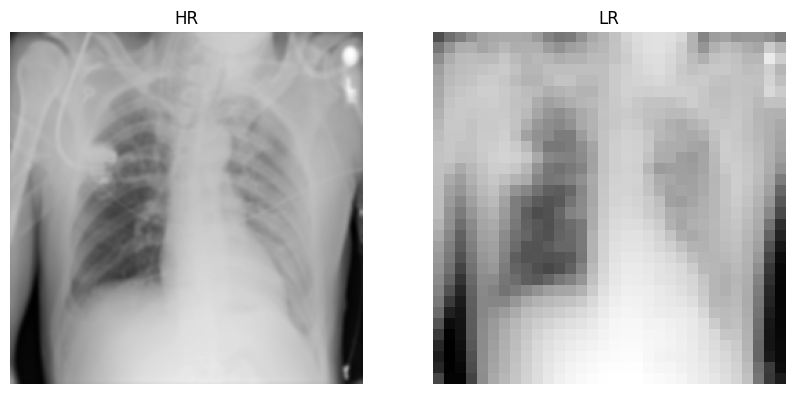

In [7]:
def preprocess_images(image_list, high_resolution_shape, low_resolution_shape):
    hr_images = []
    lr_images = []
    
    for img_path in image_list:
        img = imread(img_path, mode='F')  # Read image in grayscale and float
        img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
    
        img_hr = imresize(img, high_resolution_shape[:2], anti_aliasing=True)  # Update here
        img_lr = imresize(img, low_resolution_shape[:2], anti_aliasing=True)  # Update here
    
        # Expand dimensions to match (height, width, 1)
        img_hr = np.expand_dims(img_hr, axis=-1)
        img_lr = np.expand_dims(img_lr, axis=-1)
    
        # Random horizontal flip
        if np.random.random() < 0.5:
            img_hr = np.fliplr(img_hr)
            img_lr = np.fliplr(img_lr)
    
        hr_images.append(img_hr)
        lr_images.append(img_lr)
    
    return np.array(hr_images), np.array(lr_images)

# Process images
hr_images, lr_images = preprocess_images(image_list, high_resolution_shape, low_resolution_shape)

# Normalize images for visualization
hr_images_vis = (hr_images * 2.0) - 1.0
lr_images_vis = (lr_images * 2.0) - 1.0

# Display sample images
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
idx = np.random.randint(0, len(hr_images))
titles = ['HR', 'LR']
images = [hr_images_vis[idx].squeeze(), lr_images_vis[idx].squeeze()]

for i, img in enumerate(images):
    ax[i].imshow((img + 1) / 2.0, cmap='gray')  # Ensure grayscale visualization
    ax[i].axis("off")
    ax[i].set_title(titles[i])

plt.show()

In [8]:
def residual_block(x):

    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Add()([res, x])
    
    return res

In [54]:
def build_generator():
    
    # use 16 residual blocks in generator
    residual_blocks = 16
    momentum = 0.8
    
    # input LR dimension: 4x downsample of HR
    input_shape = (64, 64, 1)
    
    # input for the generator
    input_layer = Input(shape=input_shape)
    
    # pre-residual block: conv layer before residual blocks 
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    
    # add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)
    
    # post-residual block: conv and batch-norm layer after residual blocks
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    
    # take the sum of pre-residual block(gen1) and post-residual block(gen2)
    gen3 = Add()([gen2, gen1])
    
    # upsampling
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    
    # upsampling
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    
    # conv layer at the output
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)
    
    # model 
    model = Model(inputs=[input_layer], outputs=[output], name='generator')

    return model

generator = build_generator()

In [9]:
generator = build_generator()

In [9]:
def build_generator():
    
    # use 16 residual blocks in generator
    residual_blocks = 16
    momentum = 0.8
    
    # input LR dimension: 4x downsample of HR
    input_shape = (32, 32, 3)
    
    # input for the generator
    input_layer = Input(shape=input_shape)
    
    # pre-residual block: conv layer before residual blocks 
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    
    # add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)
    
    # post-residual block: conv and batch-norm layer after residual blocks
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    
    # add a 1x1 conv layer to match shapes before the addition operation
    gen1_resize = Conv2D(filters=64, kernel_size=1, strides=1, padding='same')(gen1)
    
    # take the sum of pre-residual block(gen1) and post-residual block(gen2)
    gen3 = Add()([gen2, gen1_resize])
    
    # upsampling
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    
    # upsampling
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    
    # upsampling
    gen6 = UpSampling2D(size=2)(gen5)
    gen6 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen6)
    gen6 = Activation('relu')(gen6)
    
    # conv layer at the output
    gen7 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen6)
    output = Activation('tanh')(gen7)
    
    # model 
    model = Model(inputs=[input_layer], outputs=[output], name='generator')

    return model

In [10]:
generator = build_generator()
#generator.summary()

In [11]:
def build_discriminator():
    
    # define hyperparameters
    leakyrelu_alpha = 0.2
    momentum = 0.8
    
    # the input is the HR shape
    input_shape = (256, 256, 3)
    
    # input layer for discriminator
    input_layer = Input(shape=input_shape)
    
    # 8 convolutional layers with batch normalization  
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)
    
    # fully connected layer 
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)
    
    # last fully connected layer - for classification 
    output = Dense(units=1, activation='sigmoid')(dis9)
    model = Model(inputs=[input_layer], outputs=output, name='discriminator')
    
    return model

In [12]:
discriminator = build_discriminator()
discriminator.trainable = True
discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [13]:
VGG19_base = VGG19(weights="imagenet")

In [21]:
def build_VGG19():
    
    input_shape = (256, 256, 3)
    VGG19_base.outputs = [VGG19_base.get_layer('block5_conv2').output]
    input_layer = Input(shape=input_shape)
    features = VGG19_base(input_layer)
    model = Model(inputs=[input_layer], outputs=[features])
    
    return model

In [23]:
from keras.applications import VGG19
from keras.layers import Input
from keras.models import Model

In [14]:
def build_VGG19():
    input_shape = (256, 256, 3)
    
    # Load the VGG19 model with ImageNet weights, excluding the top layers
    VGG19_base = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
    
    # Extract features from the 'block5_conv2' layer
    features = VGG19_base.get_layer('block5_conv2').output
    
    # Create a new model with the same input shape and desired outputs
    model = Model(inputs=VGG19_base.input, outputs=features)
    
    return model

# Example of how to create the model
fe_model = build_VGG19()
fe_model.trainable = False
fe_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])  # Adjust optimizer as needed

In [14]:
fe_model = build_VGG19()
fe_model.trainable = False
fe_model.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

In [15]:
def build_adversarial_model(generator, discriminator, feature_extractor):
    
    # input layer for high-resolution images
    input_high_resolution = Input(shape=high_resolution_shape)

    # input layer for low-resolution images
    input_low_resolution = Input(shape=low_resolution_shape)

    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator(input_low_resolution)

    # extract feature maps from generated images
    features = feature_extractor(generated_high_resolution_images)
    
    # make a discriminator non-trainable 
    discriminator.trainable = False
    discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

    # discriminator will give us a probability estimation for the generated high-resolution images
    probs = discriminator(generated_high_resolution_images)


    adversarial_model = Model(
        inputs=[input_low_resolution, input_high_resolution],
        outputs=[probs, features]
    )

    adversarial_model.compile(
        loss=['binary_crossentropy', 'mse'],
        loss_weights=[1e-3, 1],
        optimizer=common_optimizer
    )

    return adversarial_model

In [16]:
adversarial_model = build_adversarial_model(generator, discriminator, fe_model)

In [17]:
# initialize 

losses = {"d_history":[], "g_history":[]}
psnr = {'psnr_quality': []}
ssim = {'ssim_quality': []}

In [ ]:
import os

# Ensure the directory exists
save_path = "C:/Users/Admin/Downloads/images"
os.makedirs(save_path, exist_ok=True)

# Now save the images to the desired path
path = os.path.join(save_path, "img_{}_{}".format(epoch, index))
save_images(hr_images[index], lr_images[index], img, path=path)


In [83]:
for epoch in range(4000):

    d_history = []
    g_history = []
    

    
    """
    Train the discriminator network
    """
    hr_images, lr_images = sample_images(image_list, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator.predict(lr_images)
    
    # generate a batch of true and fake labels 
    real_labels = np.ones((batch_size, 16, 16, 1))
    fake_labels = np.zeros((batch_size, 16, 16, 1))
    
 
    d_loss_real = discriminator.train_on_batch(hr_images, real_labels)
    d_loss_real =  np.mean(d_loss_real)
    d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)
    d_loss_fake =  np.mean(d_loss_fake)
    
    # calculate total loss of discriminator as average loss on true and fake labels
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    losses['d_history'].append(d_loss)
   

    """
        Train the generator network
    """
      
    # sample a batch of images    
    hr_images, lr_images = sample_images(image_list, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    # extract feature maps for true high-resolution images
    image_features = fe_model.predict(hr_images)

    # train the generator
    g_loss = adversarial_model.train_on_batch([lr_images, hr_images], [real_labels, image_features])
    losses['g_history'].append(0.5 * (g_loss[1]))

    # calculate the psnr  
    ps = compute_psnr(hr_images, generated_high_resolution_images) 
    psnr['psnr_quality'].append(ps)
            
    # calculate the ssim 
    ss = compute_ssim(hr_images, generated_high_resolution_images)   
    ssim['ssim_quality'].append(ss)
    
    data_ke = epoch + 1    
    print("Epoch ke {}  PSNR {}  SSIM {}".format(data_ke, ps.numpy(), ss.numpy()))

    
    
    """
        save and print image samples
    """
    if epoch % 50 == 0:
        
        hr_images, lr_images = sample_images(image_list, 
                                             batch_size=batch_size,
                                             low_resolution_shape=low_resolution_shape,
                                             high_resolution_shape=high_resolution_shape)
    
    
        # normalize the images
        hr_images = hr_images / 127.5 - 1.
        lr_images = lr_images / 127.5 - 1.
    
    
        generated_images = generator.predict_on_batch(lr_images)
    
        for index, img in enumerate(generated_images):
            if index < 1:   # comment this line to display all the images
                save_images(hr_images[index], lr_images[index], img,
                            path="C:/Users/Admin/Downloads/img_{}_{}".format(epoch, index))  

C:\Users\Admin\AppData\Local\Temp\ipykernel_27040\3609683015.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path, mode='RGB')  # For RGB images


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:77: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [18]:
import tensorflow as tf

In [20]:
for epoch in range(1000):

    d_history = []
    g_history = []
    

    
    """
    Train the discriminator network
    """
    hr_images, lr_images = sample_images(image_list, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator.predict(lr_images)
    
    # generate a batch of true and fake labels 
    real_labels = np.ones((batch_size, 16, 16, 1))
    fake_labels = np.zeros((batch_size, 16, 16, 1))
    
 
    d_loss_real = discriminator.train_on_batch(hr_images, real_labels)
    d_loss_real =  np.mean(d_loss_real)
    d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)
    d_loss_fake =  np.mean(d_loss_fake)
    
    # calculate total loss of discriminator as average loss on true and fake labels
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    losses['d_history'].append(d_loss)
   

    """
        Train the generator network
    """
      
    # sample a batch of images    
    hr_images, lr_images = sample_images(image_list, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    # extract feature maps for true high-resolution images
    image_features = fe_model.predict(hr_images)

    # train the generator
    g_loss = adversarial_model.train_on_batch([lr_images, hr_images], [real_labels, image_features])

# Handle g_loss types safely
if tf.is_tensor(g_loss) or np.ndim(g_loss) == 0:
    # Case 1: Scalar tensor or float
    losses['g_history'].append(float(g_loss))
elif hasattr(g_loss, '__len__') and len(g_loss) > 1:
    # Case 2: List with multiple losses
    losses['g_history'].append(float(g_loss[1]))  # Assuming content loss is at index 1
else:
    # Fallback
    losses['g_history'].append(float(g_loss if hasattr(g_loss, '__float__') else g_loss[0]))
    # calculate the psnr  
    ps = compute_psnr(hr_images, generated_high_resolution_images) 
    psnr['psnr_quality'].append(ps)
            
    # calculate the ssim 
    ss = compute_ssim(hr_images, generated_high_resolution_images)   
    ssim['ssim_quality'].append(ss)
    
    data_ke = epoch + 1    
    print("Epoch ke {}  PSNR {}  SSIM {}".format(data_ke, ps.numpy(), ss.numpy()))

    
    
    """
        save and print image samples
    """
    if epoch % 50 == 0:
        
        hr_images, lr_images = sample_images(image_list, 
                                             batch_size=batch_size,
                                             low_resolution_shape=low_resolution_shape,
                                             high_resolution_shape=high_resolution_shape)
    
    
        # normalize the images
        hr_images = hr_images / 127.5 - 1.
        lr_images = lr_images / 127.5 - 1.
    
    
        generated_images = generator.predict_on_batch(lr_images)
    
        for index, img in enumerate(generated_images):
            if index < 1:   # comment this line to display all the images
                save_images(hr_images[index], lr_images[index], img,
                            path="C:/Users/Admin/Downloads/img_{}_{}".format(epoch, index))  

C:\Users\Admin\AppData\Local\Temp\ipykernel_21180\3301622914.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imread(img, as_gray=False, pilmode='RGB')


TypeError: The keyword `as_gray` is no longer supported.Use `mode='F'` for a backward-compatible result, or  `mode='L'` for an integer-valued result.

In [82]:
def sample_images(image_list, batch_size, high_resolution_shape, low_resolution_shape):
    """Pre-process a batch of training images"""
    
    # Randomly sample a batch of images
    images_batch = np.random.choice(image_list, size=batch_size)
    
    lr_images = []
    hr_images = []
    
    for img_path in images_batch:
        try:
            # Updated image loading - using mode instead of as_gray
            img = imread(img_path, mode='RGB')  # For RGB images
            img = img.astype(np.float32)
            
            # Resize images
            img_hr = imresize(img, high_resolution_shape)
            img_lr = imresize(img, low_resolution_shape)
            
            # Random horizontal flip
            if np.random.random() < 0.5:
                img_hr = np.fliplr(img_hr)
                img_lr = np.fliplr(img_lr)
            
            hr_images.append(img_hr)
            lr_images.append(img_lr)
            
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            continue
    
    # Convert lists to numpy arrays
    return np.array(hr_images), np.array(lr_images)

In [84]:
print(adversarial_model.output_names)  # Should show multiple outputs if using multiple losses

ListWrapper(['discriminator', 'functional_9'])


In [ ]:
# Confirm the data type of `image_list` is a list
if isinstance(image_list, list):
    print("image_list is a valid list")
else:
    raise TypeError("image_list should be a list of image paths, not a string")


In [12]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain
    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis = 1)
        plt.figure(figsize = (12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap = 'gray')
            plt.title(ys[i])
        plt.show()
    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024, )(x)
        x = layers.Dense(8*8*filters[0],
                         kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides)(x)
        x = Conv2DTranspose(3, kernel_size = self.kernel_size, padding = padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs = [inputs, labels],
                                           outputs = x,
                                           name = 'generator')
    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides,
                      kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha = 0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1, )(x)
        labelsOutput = Dense(256,
                             kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2,)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs = inputs,
                                               outputs = [outputs, labelsOutput],
                                               name = 'discriminator')
    def build(self,):
        generatorInput = layers.Input(shape = (self.latent_space))
        discriminatorInput = layers.Input(shape = (self.image_shape))
        labelsInput = layers.Input(shape = (2, ))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss = ['mse', 'binary_crossentropy'],
                 optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta,
                                                        weight_decay = self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs = [generatorInput, labelsInput],
                           outputs = D(G([generatorInput, labelsInput])))
        GAN.compile(loss = ['mse', 'binary_crossentropy'],
                   optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta*0.5,
                                                          weight_decay = self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN
    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size = (self.batch_size, ))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape = (self.batch_size, ))
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size = (self.batch_size)),
                                                      num_classes = 2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose = 0))
            fakeTag = tf.zeros(shape = (self.batch_size, ))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 5000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag,
                                                                                                                dlossLabels,
                                                                                                                glossTag,
                                                                                                                glossLabels))
                self.samples(G, noize, fakeLabels)

In [13]:
acgan = Acgan(eta = 0.0001, batch_size = 32, epochs = 4000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 3), kernel_size = 5)

In [28]:
import torch
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np
import random


class mydata(Dataset):
    def __init__(self, LR_path, GT_path, in_memory = True, transform = None):
        
        self.LR_path = LR_path
        self.GT_path = GT_path
        self.in_memory = in_memory
        self.transform = transform
        
        self.LR_img = sorted(os.listdir(LR_path))
        self.GT_img = sorted(os.listdir(GT_path))
        
        if in_memory:
            self.LR_img = [np.array(Image.open(os.path.join(self.LR_path, lr)).convert("RGB")).astype(np.uint8) for lr in self.LR_img]
            self.GT_img = [np.array(Image.open(os.path.join(self.GT_path, gt)).convert("RGB")).astype(np.uint8) for gt in self.GT_img]
        
    def __len__(self):
        
        return len(self.LR_img)
        
    def __getitem__(self, i):
        
        img_item = {}
        
        if self.in_memory:
            GT = self.GT_img[i].astype(np.float32)
            LR = self.LR_img[i].astype(np.float32)
            
        else:
            GT = np.array(Image.open(os.path.join(self.GT_path, self.GT_img[i])).convert("RGB"))
            LR = np.array(Image.open(os.path.join(self.LR_path, self.LR_img[i])).convert("RGB"))

        img_item['GT'] = (GT / 127.5) - 1.0
        img_item['LR'] = (LR / 127.5) - 1.0
                
        if self.transform is not None:
            img_item = self.transform(img_item)
            
        img_item['GT'] = img_item['GT'].transpose(2, 0, 1).astype(np.float32)
        img_item['LR'] = img_item['LR'].transpose(2, 0, 1).astype(np.float32)
        
        return img_item
    
    
class testOnly_data(Dataset):
    def __init__(self, LR_path, in_memory = True, transform = None):
        
        self.LR_path = LR_path
        self.LR_img = sorted(os.listdir(LR_path))
        self.in_memory = in_memory
        if in_memory:
            self.LR_img = [np.array(Image.open(os.path.join(self.LR_path, lr))) for lr in self.LR_img]
        
    def __len__(self):
        
        return len(self.LR_img)
        
    def __getitem__(self, i):
        
        img_item = {}
        
        if self.in_memory:
            LR = self.LR_img[i]
            
        else:
            LR = np.array(Image.open(os.path.join(self.LR_path, self.LR_img[i])))

        img_item['LR'] = (LR / 127.5) - 1.0                
        img_item['LR'] = img_item['LR'].transpose(2, 0, 1).astype(np.float32)
        
        return img_item


class crop(object):
    def __init__(self, scale, patch_size):
        
        self.scale = scale
        self.patch_size = patch_size
        
    def __call__(self, sample):
        LR_img, GT_img = sample['LR'], sample['GT']
        ih, iw = LR_img.shape[:2]
        
        ix = random.randrange(0, iw - self.patch_size +1)
        iy = random.randrange(0, ih - self.patch_size +1)
        
        tx = ix * self.scale
        ty = iy * self.scale
        
        LR_patch = LR_img[iy : iy + self.patch_size, ix : ix + self.patch_size]
        GT_patch = GT_img[ty : ty + (self.scale * self.patch_size), tx : tx + (self.scale * self.patch_size)]
        
        return {'LR' : LR_patch, 'GT' : GT_patch}

class augmentation(object):
    
    def __call__(self, sample):
        LR_img, GT_img = sample['LR'], sample['GT']
        
        hor_flip = random.randrange(0,2)
        ver_flip = random.randrange(0,2)
        rot = random.randrange(0,2)
    
        if hor_flip:
            temp_LR = np.fliplr(LR_img)
            LR_img = temp_LR.copy()
            temp_GT = np.fliplr(GT_img)
            GT_img = temp_GT.copy()
            
            del temp_LR, temp_GT
        
        if ver_flip:
            temp_LR = np.flipud(LR_img)
            LR_img = temp_LR.copy()
            temp_GT = np.flipud(GT_img)
            GT_img = temp_GT.copy()
            
            del temp_LR, temp_GT
            
        if rot:
            LR_img = LR_img.transpose(1, 0, 2)
            GT_img = GT_img.transpose(1, 0, 2)
        
        
        return {'LR' : LR_img, 'GT' : GT_img}
        


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms 


class MeanShift(nn.Conv2d):
    def __init__(
        self, rgb_range = 1,
        norm_mean=(0.485, 0.456, 0.406), norm_std=(0.229, 0.224, 0.225), sign=-1):

        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(norm_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1) / std.view(3, 1, 1, 1)
        self.bias.data = sign * rgb_range * torch.Tensor(norm_mean) / std
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        for p in self.parameters():
            p.requires_grad = False


class perceptual_loss(nn.Module):

    def __init__(self, vgg):
        super(perceptual_loss, self).__init__()
        self.normalization_mean = [0.485, 0.456, 0.406]
        self.normalization_std = [0.229, 0.224, 0.225]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.transform = MeanShift(norm_mean = self.normalization_mean, norm_std = self.normalization_std).to(self.device)
        self.vgg = vgg
        self.criterion = nn.MSELoss()
    def forward(self, HR, SR, layer = 'relu5_4'):
        ## HR and SR should be normalized [0,1]
        hr = self.transform(HR)
        sr = self.transform(SR)
        
        hr_feat = getattr(self.vgg(hr), layer)
        sr_feat = getattr(self.vgg(sr), layer)
        
        return self.criterion(hr_feat, sr_feat), hr_feat, sr_feat

class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]


In [ ]:
pip install torchvision


In [ ]:
from mode import *
import argparse


parser = argparse.ArgumentParser()

def str2bool(v):
    return v.lower() in ('true')

parser.add_argument("--LR_path", type = str, default = '../dataSet/DIV2K/DIV2K_train_LR_bicubic/X4')
parser.add_argument("--GT_path", type = str, default = '../dataSet/DIV2K/DIV2K_train_HR/')
parser.add_argument("--res_num", type = int, default = 16)
parser.add_argument("--num_workers", type = int, default = 0)
parser.add_argument("--batch_size", type = int, default = 16)
parser.add_argument("--L2_coeff", type = float, default = 1.0)
parser.add_argument("--adv_coeff", type = float, default = 1e-3)
parser.add_argument("--tv_loss_coeff", type = float, default = 0.0)
parser.add_argument("--pre_train_epoch", type = int, default = 8000)
parser.add_argument("--fine_train_epoch", type = int, default = 4000)
parser.add_argument("--scale", type = int, default = 4)
parser.add_argument("--patch_size", type = int, default = 24)
parser.add_argument("--feat_layer", type = str, default = 'relu5_4')
parser.add_argument("--vgg_rescale_coeff", type = float, default = 0.006)
parser.add_argument("--fine_tuning", type = str2bool, default = False)
parser.add_argument("--in_memory", type = str2bool, default = True)
parser.add_argument("--generator_path", type = str)
parser.add_argument("--mode", type = str, default = 'train')

args = parser.parse_args()

if args.mode == 'train':
    train(args)
    
elif args.mode == 'test':
    test(args)
    
elif args.mode == 'test_only':
    test_only(args)


In [ ]:
pip install git+https://github.com/tensorlayer/tensorlayerx.git 

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision.models import vgg19
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import cv2
import numpy as np

# Define the Generator (simplified SRGAN architecture)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Initial convolution block
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, 9, padding=4),
            nn.PReLU()
        )
        # Residual blocks (simplified, add more as per original SRGAN)
        self.res_blocks = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64)
        )
        # Upsampling layers (for 4x upscaling)
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, 3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(64, 256, 3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        # Final output layer
        self.final = nn.Conv2d(64, 3, 9, padding=4)

    def forward(self, x):
        x = self.initial(x)
        residual = x
        x = self.res_blocks(x)
        x = x + residual  # Skip connection
        x = self.upsample(x)
        x = self.final(x)
        return torch.tanh(x)

# Function to load and preprocess image
def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((25, 25))  # Assuming input is 25x25 based on "blurred 25"
    transform = ToTensor()
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

# Function to save enhanced image
def save_image(tensor, output_path):
    img = ToPILImage()(tensor.squeeze(0).cpu())
    img.save(output_path)

# Main processing function
def enhance_images(input_dir, output_dir, model_path):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load the pre-trained generator
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator = Generator().to(device)
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval()

    # Process each image in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, f"enhanced_{filename}")

            # Load and preprocess image
            img_tensor = load_image(input_path).to(device)

            # Enhance image with SRGAN
            with torch.no_grad():
                enhanced_tensor = generator(img_tensor)

            # Save the enhanced image
            save_image(enhanced_tensor, output_path)
            print(f"Enhanced {filename} saved to {output_path}")

# Paths
input_dir = "C:/Users/Admin/Downloads/Telegram Desktop/blurred 25"
output_dir = "C:/Users/Admin/Downloads/Telegram Desktop/enhanced_output"
model_path = "path/to/your/pretrained_srgan.pth"  # Replace with actual model path

# Run the enhancement
if __name__ == "__main__":
    enhance_images(input_dir, output_dir, model_path)